In [1]:
# importing necessary libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

import librosa
import librosa.display
from IPython import display

import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch import optim
import os
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from PIL import ImageDraw
import math
import cv2

In [2]:
audio_files = glob("C:/Users/BMSSA_16/Desktop/Itnl_Study/datasets/F1_ALS_F79_KAJ_49847901_20191223_C1.wav")

In [3]:
y, sr = librosa.load(audio_files[0])

In [4]:
print("Type: ", type(y))
print("Shape: ", y.shape)
y

Type:  <class 'numpy.ndarray'>
Shape:  (281306,)


array([-0.00893554, -0.01291948, -0.00900679, ..., -0.00742002,
       -0.00577388, -0.00515038], dtype=float32)

In [5]:
y, sr = librosa.load(audio_files[0], sr = 44100)

In [6]:
print("Type: ", type(y))
print("Shape: ", y.shape)
y

Type:  <class 'numpy.ndarray'>
Shape:  (562612,)


array([-0.01242065, -0.012146  , -0.01174927, ..., -0.00543213,
       -0.00488281, -0.00488281], dtype=float32)

In [7]:
display.Audio(audio_files[0])

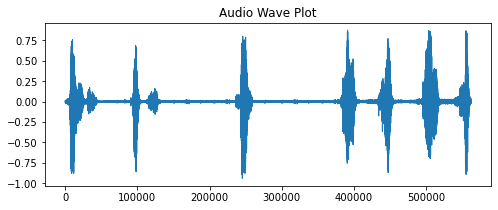

In [8]:
pd.Series(y).plot(figsize = (8, 3), lw = 1)
plt.title("Audio Wave Plot")
plt.show()

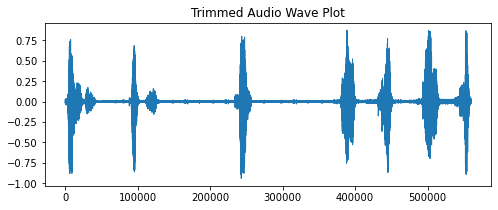

In [9]:
trimmed_y, index = librosa.effects.trim(y, top_db = 35)
pd.Series(trimmed_y).plot(figsize = (8, 3), lw = 1)
plt.title("Trimmed Audio Wave Plot")
plt.show()

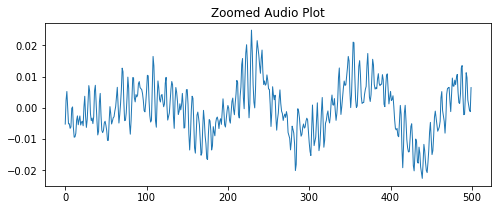

In [10]:
pd.Series(trimmed_y[25000:25500]).plot(figsize = (8, 3), lw = 1)
plt.title("Zoomed Audio Plot")
plt.show()

In [11]:
transformed_y = librosa.stft(y)
db = librosa.amplitude_to_db(abs(transformed_y))
db.shape

(1025, 1099)

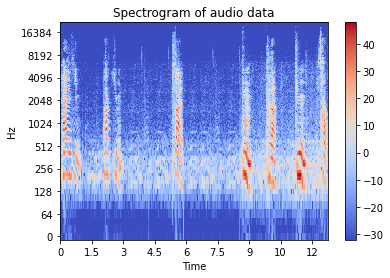

In [12]:
image = librosa.display.specshow(db, sr = sr, x_axis = "time", y_axis = "log")
plt.colorbar(image)
plt.title("Spectrogram of audio data")
plt.show()

In [13]:
S = librosa.feature.melspectrogram(y=y, sr=sr)

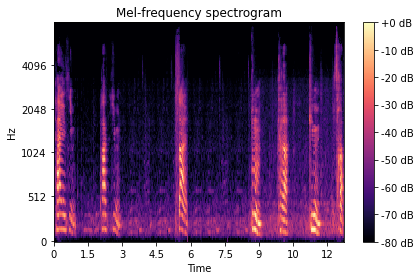

In [14]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
#그래프를 이미지 파일로 저장
plt.savefig('C:/Users/BMSSA_16/Desktop/Itnl_Study/datasets/F1_C1_Test.png', dpi=300, facecolor='white', edgecolor='black',
            orientation='portrait', format='png', transparent=False,
            bbox_inches='tight', pad_inches=0.1)
plt.tight_layout()
plt.show()

torch.Size([1, 3, 64, 64])


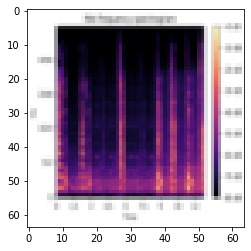

In [15]:
IMG_SIZE = 64
BATCH_SIZE = 1

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

class CustomImageDataset(Dataset):
    def __init__(self, image_path, transform=None):
        # 이미지 로드
        self.data = cv2.imread(image_path)
        self.data = cv2.cvtColor(self.data, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식으로 이미지를 로드
        self.transform = transform

    def __len__(self):
        # 여기서는 이미지 한 장만 처리하므로 길이를 1로 설정
        return 1

    def __getitem__(self, idx):
        # 이미지를 PIL 이미지로 변환
        image = Image.fromarray(self.data)
        
        # 변환 적용
        if self.transform:
            image = self.transform(image)

        return image

# 전처리 단계 정의
transformations = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 정규화
])

# 데이터셋 객체 생성
dataset = CustomImageDataset('C:/Users/BMSSA_16/Desktop/Itnl_Study/datasets/F1_C1_Test.png', transform=transformations)

# DataLoader 설정
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# DataLoader를 사용하여 데이터 확인
for images in dataloader:
    print(images.shape)  # 출력하여 텐서 크기 확인
    show_tensor_image(images)  # 이미지 출력

In [16]:
def prepare_noise_schedule(noise_steps, beta_start=0.00001, beta_end=0.02):
        return torch.linspace(beta_start, beta_end, noise_steps)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
T = 50  # 전체 타임스텝 설정
beta = prepare_noise_schedule(noise_steps=T).to(device)
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, axis=0)

# Forward Samples

In [18]:
def cosine_beta_schedule(timesteps, s=0.00001, device=torch.device('cpu')):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, device=device)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

In [19]:
def linear_beta_schedule(timesteps, start = 0.00001, end = 0.02, device=torch.device('cpu')):
    return torch.linspace(start, end, timesteps)

In [20]:
def quadrratic_beta_schedule(timesteps, start = 0.00001, end = 0.02, device=torch.device('cpu')):
    return torch.linspace(start ** 0.5, end ** 0.5, timesteps) ** 2

# ---------------------------------------------------------------------------------

In [21]:
def forward_diffusion_sample(x, t, betas, device=torch.device('cpu')):
    noise = torch.randn_like(x, device=device)  # device 추가
    alpha = 1.0 - betas[t]  # t에 해당하는 베타 값 사용
    alpha_hat = torch.cumprod(torch.tensor([alpha], device=device), dim=0)  # device 추가

    sqrt_alpha_hat = torch.sqrt(alpha_hat)[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat)[:, None, None, None]

    # 노이즈와 결합된 이미지 반환
    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise

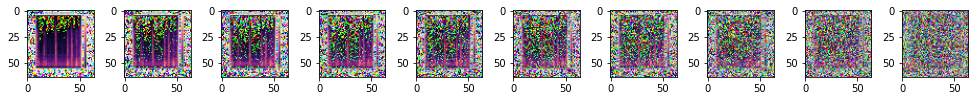

In [22]:
mel_image = next(iter(dataloader))

data = torch.tensor(mel_image, dtype=torch.float32)
    
# GPU로 이동
image_tensor = data.to(device)

# 그래프 설정
plt.figure(figsize=(15, 30))
plt.axis('off')

# 이미지 수와 스텝 사이즈 설정
num_images = 10

stepsize = int(T / num_images)

# 베타 값 생성
betas = cosine_beta_schedule(T).to(device)  # 베타 값을 GPU로 이동

# 초기 이미지 설정
x = image_tensor  # 이미지 이미 GPU에 있음

# 순차적으로 이미지에 노이즈 추가
for idx in range(0, T, stepsize):
    t = torch.tensor([idx], device=device)  # 현재 타임스텝 설정, 바로 GPU에 생성

    # forward_diffusion_sample로 노이즈 샘플링
    noisy_image, noise = forward_diffusion_sample(x, t, betas, device=device)
    
    # 이미지 시각화
    plt.subplot(1, num_images + 1, idx // stepsize + 1)
    show_tensor_image(noisy_image.cpu())  # 이미지를 CPU로 이동하여 시각화

plt.tight_layout()
plt.show()